## Image recognition using ffNNs

#### Training
Design and train a ffNN to deal with the classification task.

In [ ]:
import cv2
import pandas as pd
import tensorflow as tf

(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [ ]:
# Load architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

print('Load model')
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Load model
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 activation_14 (Activation)  (None, 150528)            0         
                                                                 
 dropout_10 (Dropout)        (None, 150528)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 150528)            602112    
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 10)                1505290   
                                                                 
 activation_15 (Activation)  (None, 10)                0         
                                           

In [ ]:
from keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, weight_decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (image, label) in group:
                images.append(cv2.resize(image, dsize=(224, 224)))
                labels.append(tf.keras.utils.to_categorical(label[0], num_classes=10))
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [ ]:
import math
import numpy as np
import tensorflow as tf

print('Training model')
epochs = 20
batch_size = 32
train_steps = math.ceil(len(y_train)/batch_size)
valid_steps = math.ceil(len(y_valid)/batch_size)
print(train_steps, valid_steps)

# Generators
train_generator = generator_images(list(zip(x_train, y_train)), batch_size, do_shuffle=True)
valid_generator = generator_images(list(zip(x_valid, y_valid)), batch_size, do_shuffle=False)
h = model.fit(train_generator, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=valid_generator, steps_per_epoch=train_steps, validation_steps=valid_steps)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
1563 313
Epoch 1/20
1561/1563 [============================>.] - ETA: 0s - loss: 2.0882 - accuracy: 0.2280
Epoch 1: val_accuracy improved from -inf to 0.32660, saving model to model.hdf5
1563/1563 [==============================] - 48s 28ms/step - loss: 2.0881 - accuracy: 0.2280 - val_loss: 1.8626 - val_accuracy: 0.3266 - lr: 0.0010
Epoch 2/20
   3/1563 [..............................] - ETA: 51s - loss: 2.0573 - accuracy: 0.2292

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1561/1563 [============================>.] - ETA: 0s - loss: 1.9594 - accuracy: 0.2722
Epoch 2: val_accuracy improved from 0.32660 to 0.35770, saving model to model.hdf5
1563/1563 [==============================] - 38s 25ms/step - loss: 1.9594 - accuracy: 0.2722 - val_loss: 1.8084 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - ETA: 0s - loss: 1.9313 - accuracy: 0.2855
Epoch 3: val_accuracy improved from 0.35770 to 0.36120, saving model to model.hdf5
1563/1563 [==============================] - 43s 27ms/step - loss: 1.9313 - accuracy: 0.2855 - val_loss: 1.7965 - val_accuracy: 0.3612 - lr: 0.0010
Epoch 4/20
1562/1563 [============================>.] - ETA: 0s - loss: 1.9220 - accuracy: 0.2913
Epoch 4: val_accuracy improved from 0.36120 to 0.36370, saving model to model.hdf5
1563/1563 [==============================] - 45s 29ms/step - loss: 1.9220 - accuracy: 0.2912 - val_loss: 1.7911 - val_accuracy: 0.3637 - lr: 0.0010
Epoch 5/20
1563/1563 [==

<Axes: >

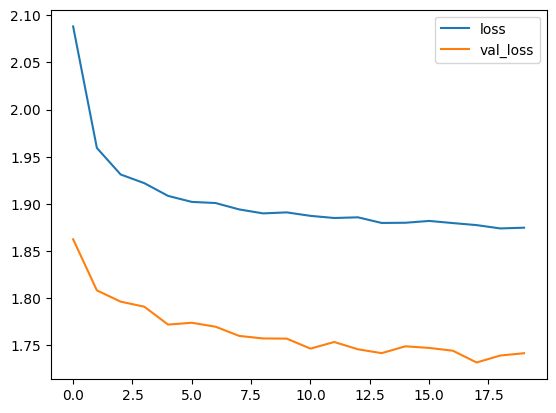

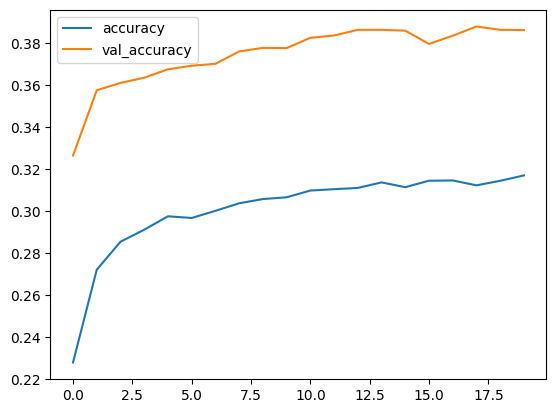

In [ ]:
history_df = pd.DataFrame(h.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

#### Validation results


In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for idx in range(len(y_valid)):
  # Generate prediction
  img = cv2.resize(x_valid[idx], dsize=(224, 224))
  img = np.expand_dims(img, axis=0)
  predictions = model.predict(img)
  # Save prediction
  pred_category = np.argmax(predictions)
  pred_score = np.max(predictions)
  y_true.append(y_valid[idx])
  y_pred.append(pred_category)
  print(y_valid[idx], pred_category)

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 61ms/step
[6] 6
1/1 [==============================] - 0s 48ms/step
[9] 1
1/1 [==============================] - 0s 32ms/step
[8] 6
1/1 [==============================] - 0s 26ms/step
[8] 8
1/1 [==============================] - 0s 25ms/step
[6] 5
1/1 [==============================] - 0s 21ms/step
[7] 7
1/1 [==============================] - 0s 19ms/step
[4] 4
1/1 [==============================] - 0s 20ms/step
[7] 6
1/1 [==============================] - 0s 17ms/step
[2] 6
1/1 [==============================] - 0s 21ms/step
[3] 4
1/1 [==============================] - 0s 19ms/step
[8] 5
1/1 [==============================] - 0s 25ms/step
[0] 0
1/1 [==============================] - 0s 16ms/step
[9] 1
1/1 [==============================] - 0s 17ms/step
[0] 0
1/1 [==============================] - 0s 17ms/step
[7] 7
1/1 [==============================] - 0s 19ms/step
[8] 8
1/1 [======

<ipython-input-30-ef52c083f6a9>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


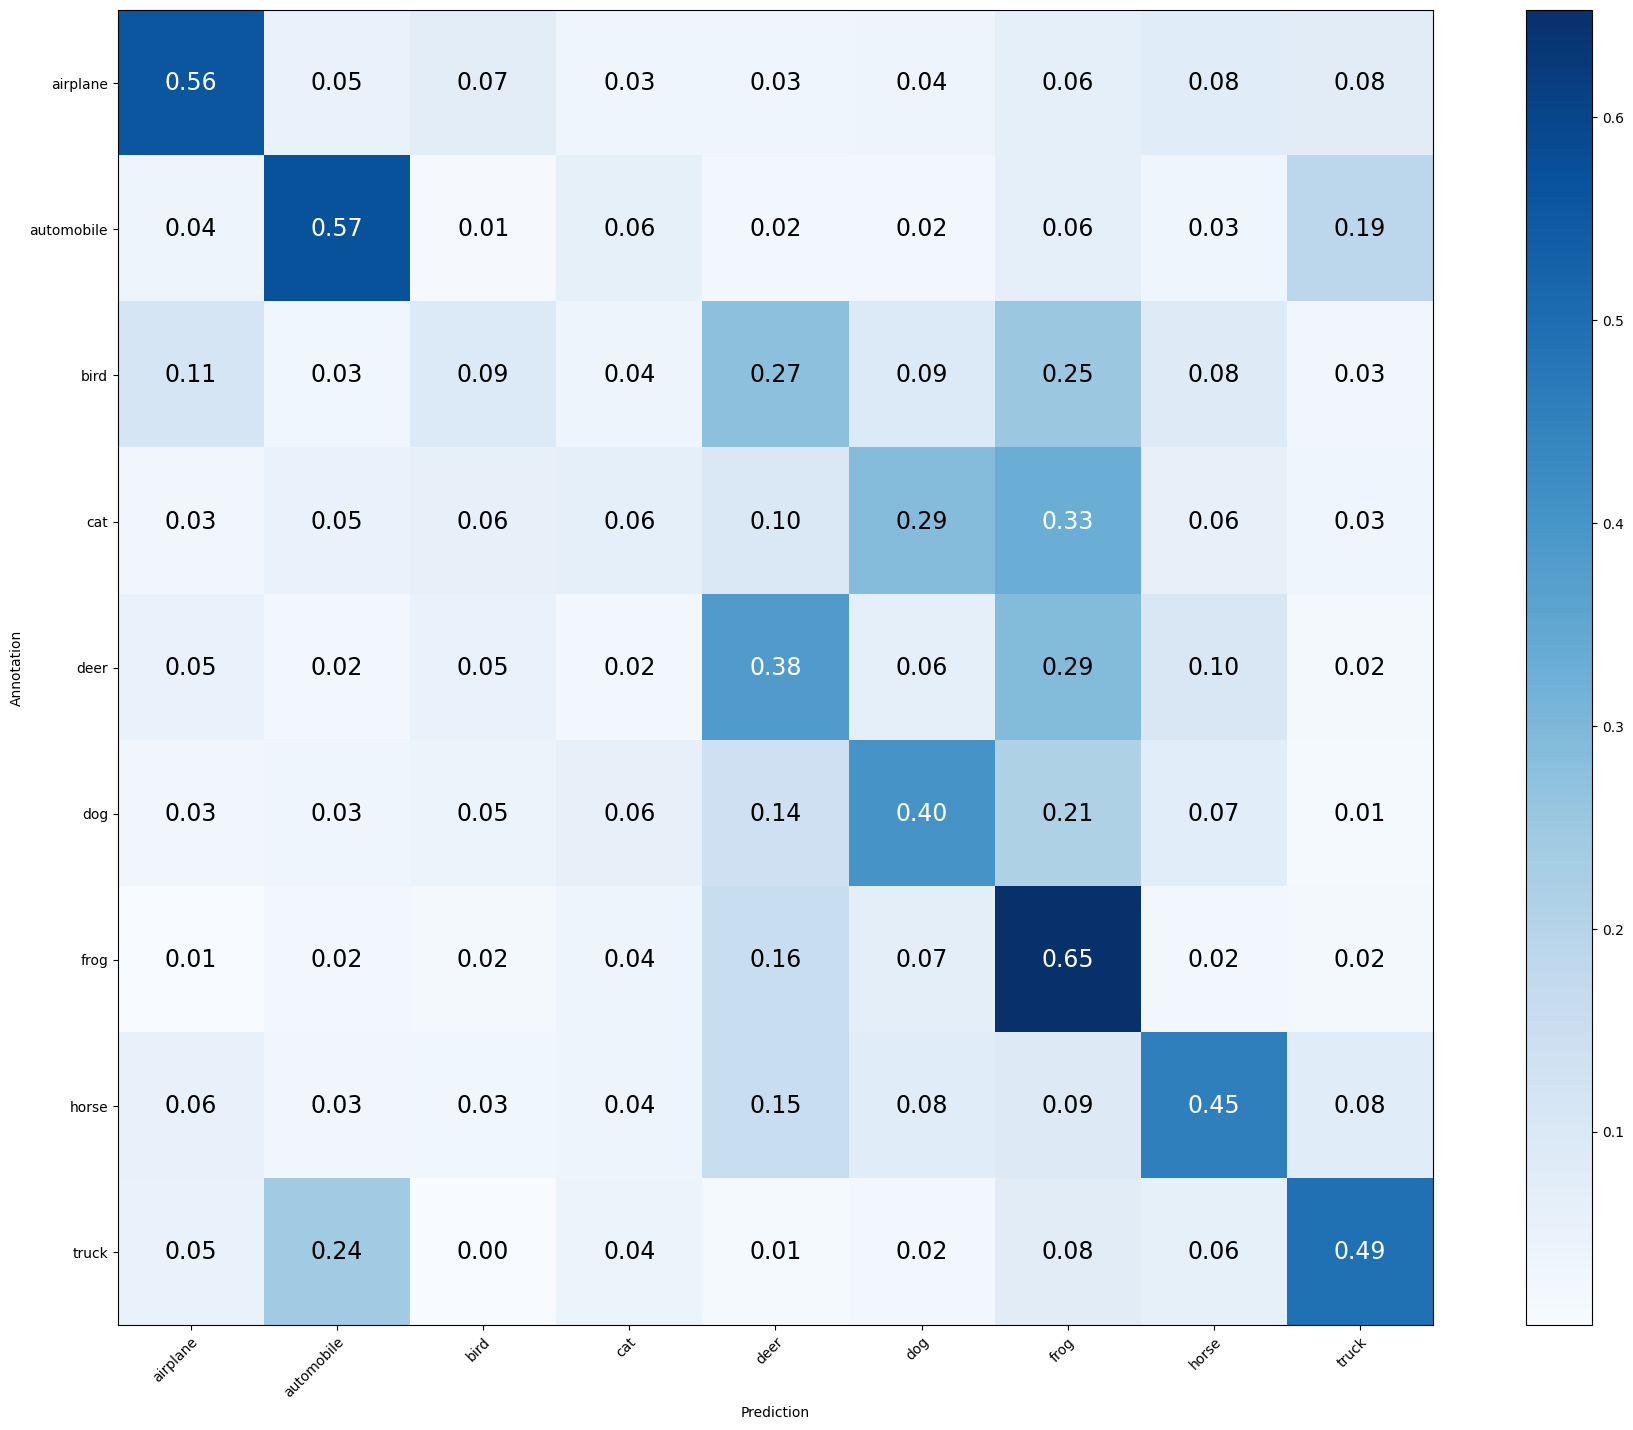

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

# Compute the confusion matrix
categories = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 9: 'ship', 9: 'truck'}
cm = confusion_matrix(y_true, y_pred, labels=list(categories.keys()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 40.083%
Mean Recall: 40.722%
Mean Precision: 39.198%
> airplane: Recall: 55.907% Precision: 54.558% Specificity: 95.480% Dice: 55.224%
> automobile: Recall: 56.863% Precision: 54.235% Specificity: 94.349% Dice: 55.518%
> bird: Recall: 9.317% Precision: 26.012% Specificity: 96.475% Dice: 13.720%
> cat: Recall: 6.178% Precision: 16.667% Specificity: 95.944% Dice: 9.015%
> deer: Recall: 38.110% Precision: 30.256% Specificity: 88.355% Dice: 33.732%
> dog: Recall: 40.084% Precision: 37.747% Specificity: 91.340% Dice: 38.880%
> frog: Recall: 65.288% Precision: 33.368% Specificity: 82.147% Dice: 44.164%
> horse: Recall: 45.464% Precision: 48.715% Specificity: 93.686% Dice: 47.033%
> truck: Recall: 49.291% Precision: 51.229% Specificity: 94.622% Dice: 50.241%


#Comentarios
En el ejemplo base propuesto, se hace uso de una capa Flatten para transformar los datos en un array 1D para poder ser utilizado como input en las siguientas capas neuronales, junto con una capa densa de 10 neuronas como output final. Para poder mejorar el desempeño del modelo, se han añadido dos capas formadas por 10 neuronas a la red de neuronas, junto con métodos regularizadores como Dropout y BatchNormalziation con el objetivo de controlar el overfitting del sistema.
Con estos cambios, hemos obteniendo un 41% de accuracy, lo cual supone una mejora de más del doble con respecto al ejemplo base (17%). Entrando un poco en detalle, se observa como el sistema tiene más dificultadas de predecir el resultado para las clases "cat" y "bird" (9% y 13.7% de f1-score), mientras que para el resto de clases, están rondando un 50% de f1-score.
Como conclusión, hemos conseguido mejorar el rendimiento de nuestro sistema, aún sabiendo que las FFNN no son una opción válida en la tarea de clasificación de imágenes, ya que todas todas las neuronas están conectadas con el resto de capas del sistema, provocando dificultades a la hora de realizar la propagación del error.